> While in today’s computer chips, multiplication takes about the same number of cycles as addition

Wait. In that case, why do we care?
Same number of cycles, isnt the same as having the same computational cost!?
Also, does Strassens algol mmake it more parallelisable?


* http://www.theoryofcomputing.org/articles/gs005/gs005.pdf
* https://en.wikipedia.org/wiki/Bilinear_map
* https://arxiv.org/abs/1011.1350

In [1]:
import numpy as np
import numpy.random as rnd

import matplotlib.pyplot as plt
%matplotlib inline

import networkx as nx

# Strassens Algol

In [2]:
# want to convert this into fast numerical code using cuda or similar!! -- http://cython.org/
# count how many times we mul
# would be cooler to overload multiplication?

In [29]:
def count(fn):  # not quite idea, want it to reset after every top level call
    counter = 0
    
    def wrapper(*args, **kwargs):
        wrapper.called += 1
        return fn(*args, **kwargs)
    
    wrapper.called = counter
    wrapper.__name__ = fn.__name__
    return wrapper

def split(matrix):  # split matrix into quarters
    row, col = matrix.shape
    m11 = matrix[:row//2, :col//2]  # top left
    m12 = matrix[:row//2, col//2:]  # top right
    m21 = matrix[row//2:, :col//2]  # bottom left
    m22 = matrix[row//2:, col//2:]  # bottom right
    return m11, m12, m21, m22

def merge(c11, c12, c21, c22):
    return np.vstack((np.hstack((c11, c12)), np.hstack((c21, c22)))) 

@count
def strassen(a, b):
    """
    For the matrix multiplication of any two matrices of 
    size (n x n), they can be viewed as a 2x2 
    matrices of 4 elements each. 
    
    [[A_11, A_12],
     [A_21, A_22]]
     
    [[B_11, B_12],
     [B_21, B_22]]
    
    Where these elements are in in some other set.
    As long as those elements have addition and 
    multiplication defined then we can reduce the 
    
    """
    if len(a) == 2:  
        # base case: 2x2 matrix
        # use regular multiplication
        # as the elements are in the reals
        mul = np.multiply 
    else:
        # else use strassens algol as the elements
        # are in the general linear group
        mul = strassen
        
    a11, a12, a21, a22 = split(a)
    b11, b12, b21, b22 = split(b)

    p1 = mul(a11 + a22, b11 + b22)
    p2 = mul(a21 + a22, b11)
    p3 = mul(a11, b12 - b22)
    p4 = mul(a22, - b11 + b21)
    p5 = mul(a11 + a12, b22)
    p6 = mul(- a11 + a21, b11 + b12)
    p7 = mul(a12 - a22, b21 + b22)

    c11 = p1 + p4 - p5 + p7
    c12 = p3 + p5
    c21 = p2 + p4
    c22 = p1 - p2 + p3 + p6

    return merge(c11, c12, c21, c22)

In [30]:
def test(shape):
    A = rnd.random(shape)
    B = rnd.random(shape)
    C = strassen(A, B)
    C_ = np.dot(A, B)
    
    error = np.sum(np.abs(C - C_))
    if error > 1e-8:
        print(error)
        raise ValueError    
test((32, 32))



$$
p_i = \sum_j \sum_k P[i, j, k] A[j] B[k] \\ 
$$

In [46]:
# TODO is it possible to write out the ps and cs in a matrix form?
# as an operator on the a11, ... b22. or on p1-p7?

P = np.array([
    # p1 = a11b11 + a11b22 + a22b11 + a22b22
    [[1, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 1]],
    # p2 = a21b11 + a22b11
    [[0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0]],
    # p3 = a11b12 - a11b22
    [[0, 1, 0, -1], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]],
    # p4 = -a22b12 + a22b21
    [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, -1, 1, 0]],
    # p5 = a11b22 + a12b22
    [[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0]],
    # p6 = -a11b11 - a11b12 + a21b11 + a21b12
    [[-1, -1, 0, 0], [0, 0, 0, 0], [1, 1, 0, 0], [0, 0, 0, 0]],
    # p7 = a21b21 + a21b22 - a22b21 - a22b22
    [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 1], [0, 0, -1, -1]]
])

C = np.array([
    # c1 = ...
    [1, 0, 0, 1, -1, 0, 1],
    [0, 0, 1, 0, 1, 0, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [1, -1, 1, 0, 0, 1, 0],
])

P = P.T
C = C.T
print(P.shape, C.shape)

MMT = np.tensordot(P, C, axes=[2,0])

MMT.shape

(4, 4, 7) (7, 4)


(4, 4, 4)

(-0.5, 7.5, 7.5, -0.5)

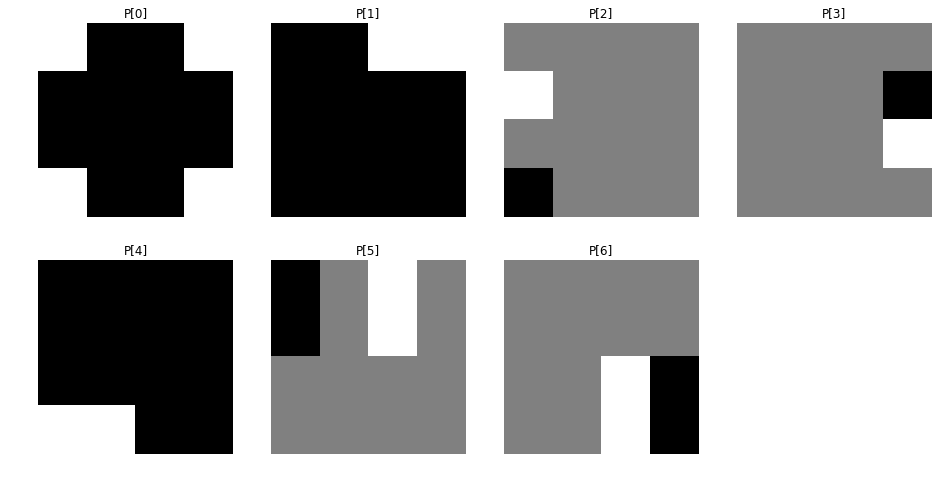

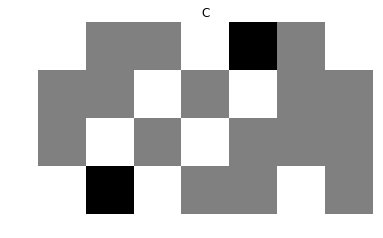

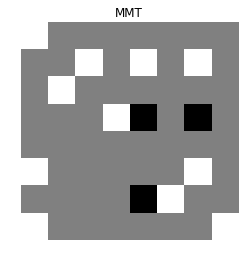

In [50]:
plt.figure(figsize=(16, 8))
for i in range(7):
    plt.subplot(2, 4, i+1)
    plt.title('P[{}]'.format(i))
    plt.imshow(P[:, :, i], cmap='gray', interpolation='nearest')
    plt.axis('off')

plt.figure()
plt.title('C')
plt.imshow(C.T, cmap='gray', interpolation='nearest')
plt.axis('off')
    
plt.figure()
plt.title('MMT')
plt.imshow(MMT.reshape(8, 8, order='C'), interpolation='nearest', cmap='gray')
plt.axis('off')



In [32]:
def mul_MMT(A, B):
    A = A.reshape(-1)
    B = B.reshape(-1)
#     result = np.einsum('i,j,ijk->k', A, B, MMT)
    result = np.einsum('i,j,ijk,kl->l', A, B, P, C)

    return result.reshape((2, 2))

def test(shape):
    A = rnd.random(shape)
    B = rnd.random(shape)
    C = mul_MMT(A, B)
    C_ = np.dot(A, B)
    
    error = np.sum(np.abs(C - C_))
    if error > 1e-8:
        print(error)
        raise ValueError

test((2,2))

[[0.474268   0.049396  ]
 [0.30047189 0.60772355]]
[0.474268   0.049396   0.30047189 0.60772355]
[0.83541532 0.15015842 0.76874738 0.53867075]
0.9546826584614915


ValueError: 

[0.00000e+00 0.00000e+00 8.00000e+00 5.70000e+01 4.00000e+02 2.80100e+03
 1.96080e+04 1.37257e+05]


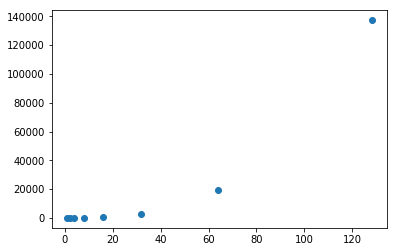

In [16]:
calls = np.zeros(8)
for i in range(2, len(calls)):
    strassen.called = 0
    test((2**i,2**i))
    calls[i] = strassen.called
    
plt.scatter(2**np.arange(8), calls)
# plt.plot(range(8))
print(calls)

In [17]:
def time(shape):
    A = rnd.random(shape)
    B = rnd.random(shape)
    %timeit C = strassen(A, B)
    %timeit C_ = np.dot(A, B)
time((16,16))

8.9 ms ± 22 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.14 µs ± 8.48 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [18]:
# HA. that is slow...
# Also profile vanilla matmul.

A cool perspective that isnt the natural way to consider tensors.
The elements of my matrix, are matrices. This makes sense if we just think of the elements of a matrix as any ring/field.

What about an extension to higher dimensional arrays?
For a 3-tensor, we would have a cube that gets split up into 8 smaller cubes?

__Wait, but why?!__ 

Why is strassen faster? What intution is there for where the algol comes from, seems rather unusual...

Simple, it uses less multiplications. Yes, but why is that possible?



[Fast Feasible and Unfeasible Matrix Multiplication Victor](?)

## Strassens algol for tensor contraction

Can we generalise strassen in a non-trivial way to tensors?

Currently (cite) best algol just reshapes tensor (in an intellgient way?) into a matrix and applies vanilla strassens algol. https://github.com/flame/tblis-strassen

WANT - if strassens does a 2d partition on matrices, can we formulate a nd partition and decompose that? So (2x2x2) x (2x2x2) is the base case for 3 dim tensors?!?


# The matrix multiplication tensor

>  However, de Groote [dG78] has shown that all 7-term decompositions of MM 2 are equivalent up to a change of basis, i.e., an instance of the GL(n)3 action (2)

ok. 
* wtf is the MM-tensor. 
* why does the MM-tensor rank have anything to do with the number of multiplications required?
* what is so special about GL(n)3? What has it got to do with MM?
* can we visualise the MM-tensor as a tensor network?


Classic result from Winograd: https://www.sciencedirect.com/science/article/pii/0024379571900097


* [Matrix multiplication algorithms from group orbits](https://arxiv.org/pdf/1612.01527.pdf)
* https://arxiv.org/pdf/1601.08229.pdf
* [](https://link.springer.com/article/10.1007%2FBF02165411)

### [Designing Strassen’s Algorithm](https://arxiv.org/pdf/1708.09398.pdf)

The matrix multiplication tensor for $n x n$ matrices is
$$
MM^{abc}_{def} = \delta^a_e \delta^b_f \delta^c_d
$$

$$
<MM \mid A \otimes B \otimes C> = tr(ABC)\\
$$

__Q:__ _No idea what is going on here... Notation!??_

> The matrix multiplication tensor MM is characterized  by its
symmetries. That is,  up to a constant, it is the unique operator fixed under the following action of $GL(n)^3$: give $X, Y, Y \in GL(n)$ we have

$$
MM = (X \otimes Y \otimes Z) \; MM \; (Z^{-1} \otimes X^{-1} \otimes Y^{-1}) \\
$$

__Q:__ _So how are we applying $MM$ here? Via matmul?_

### [The border support rank of two-by-two matrix multiplication is seven](https://arxiv.org/pdf/1705.09652.pdf)

$$
<n, n, n> = \sum_{i, j, k \in [n]} e_{ij} \otimes e_{jk} \otimes e_{ki} \\
e \in F^{n \times n} \otimes F^{n \times n} \otimes F^{n \times n} \\
$$

__Q:__ _but how can $e$ be in $F^{n \times n} $ if ... oh their notation..._

Ok, if a hypermatrix is the generalisation of a matrix to higher dims, wtf is a tensor... how can you have a tensor without representing it as a hypermatrix?

> The support of t is the set of coordinates where t has a nonzero coefficient. The support rank of t is the minimal rank of a tensor with the same support as t.


Questions !?!?

- is the MMT 3 dims or 6?
- how to construct it?

In [10]:
def MM_tensor(n): 
    # MM(a,b,c,d,e,f) = 1(ae)1(bf)1(cd)
    # A.B = C  >> (a x b) . (c x d) = (e x f) # no that doesnt seem right...
    i, j, k = np.ogrid[:n, :n, :n]
    M = np.zeros((n,n,n,n,n,n))
    
    M[i, :, :, :, i, :] = 1  # 1 if a == e
    M[:, j, :, :, :, j] = 1  # 1 if b == f
    M[:, :, k, k, :, :] = 1  # 1 if c == d
    
    # 1(ae)1(bc)1(df) makes more sense to me!?
#     M[i, :, :, :, i, :] = 1  # 1 if a == e
#     M[:, j, j, :, :, :] = 1  # 1 if b == c
#     M[:, :, :, k, :, k] = 1  # 1 if d == f
    # maybe not...??
    return M

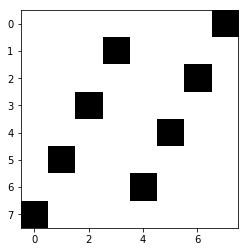

In [11]:
n = 2
M = MM_tensor(n)
plt.imshow(M.reshape((n**3,n**3)), cmap='gray')

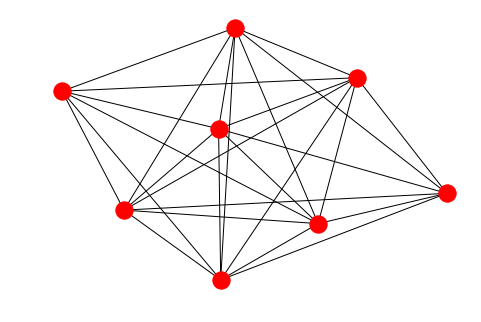

In [12]:
n = 2
m = MM_tensor(n)
m = m.reshape((n**3, -1))

g = nx.from_numpy_matrix(m)
g = nx.convert_node_labels_to_integers(g)
nx.draw(g, pos=nx.spring_layout(g))

## Rank
Hmph. Need to more research on the rank of tensors.

> The tensor rank of $v$ is the smallest number of rank-one tensors whose sum is $v$.

In [69]:
np.linalg.matrix_rank(M)

array([[[[1, 2],
         [2, 1]],

        [[1, 2],
         [2, 1]]],


       [[[1, 2],
         [2, 1]],

        [[1, 2],
         [2, 1]]]])

#### Border rank!?

The border rank of a tensor
$v \in V_1 \otimes \dots \otimes V_k$ is the smallest $r$ such than $v$ is a limit of tensors of rank at most $r$. The border rank is less than or equal to the rank, and indeed it can be strictly smaller. 

__Q:__ _How can v be a limit? The limit as rank(v) -> r? Why would that just give v?_

| n | Tensor rank $\ge$ | Tensor rank $\le$  | Border rank $\ge$ | Border rank $\le$ |
|---|---|---|---|---|
| 2 | 7 | 7 | 7 | 7 |
| 3 | 19 | 23 | 16 | 21 |
| 4 | 34 | 49 | 29 | 49 |

https://arxiv.org/pdf/1612.01527.pdf (has refs)


Approximate ranks on the 'border'?!?
[The border support rank of two-by-two matrix multiplication is seven](?)

#### Support rank (!?)

## Learning strassens algol

http://jmlr.csail.mit.edu/papers/volume17/16-074/16-074.pdf

In [20]:

import autograd.numpy as np
import autograd.numpy.random as rnd
from autograd import grad
from autograd.misc.optimizers import adam

In [21]:
def tensor_representation(params, a, b):  
    # need a regulariser on the rank?!
    # reg = np.linalg.norm(mmt.reshape((n**3, n**3)), 'nuc')
    return np.einsum('ijklmn,bij,bkl->bmn', params['mmt'], a, b)

params = {
    'mmt': rnd.standard_normal([n]*6)
}
x = np.random.random((50, 2, 2))
tensor_representation(params, x, x).shape

(50, 2, 2)

In [22]:

# def decomposed_representation(params, a, b):  # this doesnt work. why?
#     mmt = np.einsum('ij,kl,mn->ikm', params['M_a'], params['M_b'], params['M_c'])
#     return np.einsum('ijk,j,k->i', mmt, a.flatten(), b.flatten()).reshape((n,n))

def net_constructor(params):
    return np.dot(np.concatenate([params['M_a'], 
                                  params['M_b']]), 
                  params['M_c'].T)

def net_representation(params, a, b):
    x = np.concatenate([a, b], axis=1)
    
    M = net_constructor(params)
    y = np.dot(x, M)
    
    return y.reshape((a.shape[0],a.shape[1]))

In [23]:

    
def mse(y, t):
    return np.mean(np.sum(np.square(y-t), axis=1)) 
def lr_decay(n, lr):
    return lr * 0.99 ** (n / 100)

    
def train(params, fn, n, iterations=10000, lr=0.01, batch_size=50):
    losses = []
    def loss_fn(params, t, a, b):
        y = fn(params, a, b)
        return mse(y, t)

    dL = grad(loss_fn)
    g_ = 0
    for i in range(iterations):
        # construct training data
        # could/should do in batches?!
        A = rnd.standard_normal((batch_size, n**2))
        B = rnd.standard_normal((batch_size, n**2))
        T = np.zeros((batch_size, n**2))
        
        for i in range(batch_size):
            T[i, :] = np.dot(A[i, :].reshape((n,n)), B[i, :].reshape((n,n))).flatten()
        
        grads = dL(params, T, A, B)

        for k, g in grads.items():
            g_ = 0.9*g_ + g 
            params[k] -= lr_decay(i, lr)*g_
            
        L = loss_fn(params, T, A, B)
        print('\rLoss: {:.3f}'.format(L), end='', flush=True)
        losses.append(L)

    return params, losses

In [24]:
n = 2
r = 6
params = {
    'M_a': rnd.standard_normal((n**2, r)),
    'M_b': rnd.standard_normal((n**2, r)),
    'M_c': rnd.standard_normal((n**2, r)),
}

params, losses = train(params, net_representation, n=n, iterations=1000, lr=0.001)

Loss: 6.564

In [25]:
losses = np.zeros((10, 1000))
for i, r in enumerate(range(2, 12)):
    params = {
        'M_a': rnd.standard_normal((n**2, r)),
        'M_b': rnd.standard_normal((n**2, r)),
        'M_c': rnd.standard_normal((n**2, r)),
    }

    params, L = train(params, net_representation, n=n, iterations=1000, lr=0.001)
    losses[i, :] = L

Loss: 6.632

(0, 20)

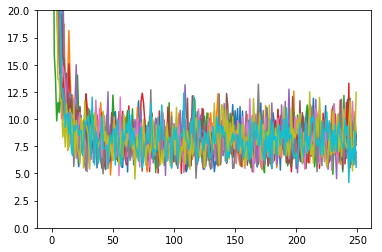

In [244]:
for i in range(10):
    plt.plot(losses[i, ::4])
    
plt.ylim(0, 20)

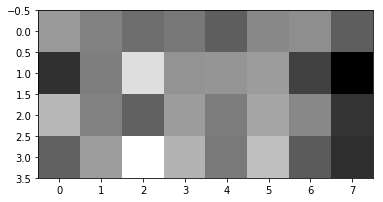

In [249]:
plt.imshow(net_constructor(params).reshape((n**2,n**3)), 
           cmap='gray', interpolation='nearest')

In [250]:
params = {
    'mmt': rnd.standard_normal([n]*6)
}

params = train(params, tensor_representation, n=n)

ValueError: ('Einstein sum subscript %s does not contain the correct number of indices for operand %d.', 'j', 1)

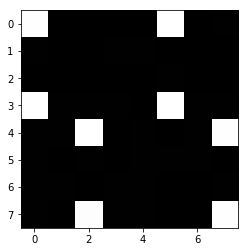

In [19]:
plt.imshow(params['mmt'].reshape((n**3,n**3)), cmap='gray', interpolation='nearest')

In [ ]:
# this is too expensive. 
# is there a better way to solve these?!?
ranks = []
for i in range(2, 10):
    params = {
        'mmt': rnd.standard_normal([i]*6)
    }

    params = train(params, tensor_representation, i, 0.001/i)
    ranks.append(np.linalg.matrix_rank(params['mmt'].reshape((i**3,i**3))))

__TODO__
- Make a toy computer that can compute a 2x2 matmul!?!